## Download necessary package

In [1]:
!pip install gensim pyvi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.3 MB/s eta 0:00:00


In [2]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.vi.300.vec.gz
!gunzip cc.vi.300.vec.gz

--2025-12-28 07:05:05--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.vi.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.249.182.81, 13.249.182.62, 13.249.182.39, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.249.182.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1235219084 (1.1G) [binary/octet-stream]
Saving to: ‘cc.vi.300.vec.gz’

cc.vi.300.vec.gz    100%[===================>]   1.15G   194MB/s    in 9.0s    

2025-12-28 07:05:15 (130 MB/s) - ‘cc.vi.300.vec.gz’ saved [1235219084/1235219084]



In [26]:
from tensorflow.keras.layers import Input, Embedding, Dense, SimpleRNN, Bidirectional, LSTM, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.models import load_model, Model
from sklearn.utils import class_weight
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
from pyvi import ViTokenizer
from keras import layers
from google import colab
import pandas as pd
import numpy as np

In [4]:
colab.drive.mount('/content/drive')
base = "/content/drive/MyDrive/CS221-NLP/Project"

Mounted at /content/drive


## Load data and word embedding

In [7]:
base = "/content/drive/MyDrive/CS221-NLP/Project"
data = pd.read_csv(base + "/Dataset/vsa_food_rv_train_clean.csv", encoding="utf-8")
X = data["Comment"]
y = data["Rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2020, test_size=0.2, stratify = y)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10326,), (10326,), (2582,), (2582,))

In [8]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(1.9638645872955496), 1: np.float64(0.6707808236975445)}


In [9]:
texts = X_train.astype(str).tolist()
labels = y_train.tolist()

texts_tokenized = [ViTokenizer.tokenize(t) for t in texts]
tokenizer = Tokenizer(oov_token="<UNK>")
tokenizer.fit_on_texts(texts_tokenized)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

print("Số lượng từ trong vocab:", len(word_index))

Số lượng từ trong vocab: 11115


In [10]:
#Padding để tất cả các câu có cùng độ dài, đảm bảo các tensor có cùng kích thước
sequences = tokenizer.texts_to_sequences(texts_tokenized)
max_len = max(len(seq) for seq in sequences)
X_train = pad_sequences(sequences, maxlen=max_len, padding='post')
print("Chiều dài dài nhất: ", max_len)

Chiều dài dài nhất:  933


In [11]:
texts_test = X_test.astype(str).tolist()
labels_test = y_test.tolist()

texts_test_tokenized = [ViTokenizer.tokenize(t) for t in texts_test]
sequences_test = tokenizer.texts_to_sequences(texts_test_tokenized)
X_test = pad_sequences(sequences_test, maxlen=max_len, padding='post')

In [12]:
ft_model = KeyedVectors.load_word2vec_format("cc.vi.300.vec", limit=50000)
embedding_dim = ft_model.vector_size
print("Số chiều embedding: ", embedding_dim)

Số chiều embedding:  300


In [13]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim)) #+1 dòng padding để index từ 1 - N
inft = 0
not_inft = 0
for word, i in word_index.items():
    if word in ft_model:
        embedding_matrix[i] = ft_model[word]
        inft += 1
    else:
        # Nếu từ không có trong FastText, gán vector ngẫu nhiên
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))
        not_inft += 1
print("Số từ có trong FastText: ", inft)
print("Số từ không có trong FastText: ", not_inft)

Số từ có trong FastText:  6144
Số từ không có trong FastText:  4971


## Define model architecture

In [14]:
class RNN:
  def __init__(self):
    return None

  def build(self):
    input = Input(shape = (max_len,))
    # Embeeding(dict_len, emb_len, weights)
    embedding = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],trainable=True)(input)
    hidden1 = SimpleRNN(128, return_sequences=True)(embedding)
    dropout1 = Dropout(0.1)(hidden1)
    hidden2 = SimpleRNN(64, return_sequences=True)(dropout1)
    dropout2 = Dropout(0.1)(hidden2)
    hidden3 = SimpleRNN(32)(dropout2)
    output = Dense(1, activation = 'sigmoid')(hidden3)
    self.model = Model(input, output)

  def train(self, x_train, y_train, epochs=5, batch_size=64, validation_split=0.2):
    self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, class_weight=class_weights)
    return history

  def load(self, model_file):
    self.model = load_model(model_file)

  def save(self, model_file):
    self.model.save(model_file)

  def summary(self):
    self.model.summary()

  def predict(self, x_test):
    return self.model.predict(x_test)

In [15]:
class BiLSTM:
  def __init__(self):
    return None

  def build(self):
    input = Input(shape = (max_len,))
    # Embeeding(dict_len, emb_len, weights)
    embedding = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],trainable=True)(input)
    hidden1 = Bidirectional(LSTM(128, return_sequences=True))(embedding)
    dropout1 = Dropout(0.1)(hidden1)
    hidden2 = Bidirectional(LSTM(64, return_sequences=True))(dropout1)
    dropout2 = Dropout(0.1)(hidden2)
    hidden3 = Bidirectional(LSTM(32))(dropout2)
    output = Dense(1, activation = 'sigmoid')(hidden3)
    self.model = Model(input, output)

  def train(self, x_train, y_train, epochs=5, batch_size=64, validation_split=0.2):
    self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, class_weight=class_weights)
    return history

  def load(self, model_file):
    self.model = load_model(model_file)

  def save(self, model_file):
    self.model.save(model_file)

  def summary(self):
    self.model.summary()

  def predict(self, x_test):
    return self.model.predict(x_test)

In [16]:
class CNN_LSTM:
  def __init__(self):
    return None

  def build(self):
    input = Input(shape = (max_len,))
    # Embeeding(dict_len, emb_len, weights)
    embedding = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],trainable=True)(input)
    conv1 = Conv1D(128, 3, activation = 'relu')(embedding)
    dropout = Dropout(0.1)(conv1)
    pool = MaxPooling1D(2)(dropout)
    lstm = LSTM(32)(pool)
    output = Dense(1, activation = 'sigmoid')(lstm)
    self.model = Model(input, output)

  def train(self, x_train, y_train, epochs=5, batch_size=64, validation_split=0.2):
    self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, class_weight=class_weights)
    return history

  def load(self, model_file):
    self.model = load_model(model_file)

  def save(self, model_file):
    self.model.save(model_file)

  def summary(self):
    self.model.summary()

  def predict(self, x_test):
    return self.model.predict(x_test)

In [17]:
def plot_history(hist):
  plt.plot(hist.history['accuracy'], label='train acc')
  plt.plot(hist.history['val_accuracy'], label='val acc')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

  # Plot loss
  plt.plot(hist.history['loss'], label='train loss')
  plt.plot(hist.history['val_loss'], label='val loss')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

## Training

In [ ]:
rnn = RNN()
rnn.build()
rnn.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 933)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_12 (Embedding)        │ (None, 933, 300)       │     3,334,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 933, 128)       │        54,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 933, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_10 (SimpleRNN)       │ (None, 933, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 933, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_11 (SimpleRNN)       │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,405,201 (12.99 MB)

 Trainable params: 3,405,201 (12.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 38s 248ms/step - accuracy: 0.4818 - loss: 0.7138 - val_accuracy: 0.5237 - val_loss: 0.6934
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 31s 239ms/step - accuracy: 0.4939 - loss: 0.7212 - val_accuracy: 0.4932 - val_loss: 0.6965
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 229ms/step - accuracy: 0.5070 - loss: 0.6913 - val_accuracy: 0.4613 - val_loss: 0.6962
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 221ms/step - accuracy: 0.5108 - loss: 0.6894 - val_accuracy: 0.4613 - val_loss: 0.7022
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 28s 219ms/step - accuracy: 0.4948 - loss: 0.6942 - val_accuracy: 0.4613 - val_loss: 0.6949
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 28s 218ms/step - accuracy: 0.5319 - loss: 0.6846 - val_accuracy: 0.4613 - val_loss: 0.6967
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 225ms/step - accuracy: 0.5010 - loss: 0.6892 - val_accuracy: 0.4613 - val_loss: 0.6990
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 28s 219ms/step - accuracy: 0.4958 - loss: 0

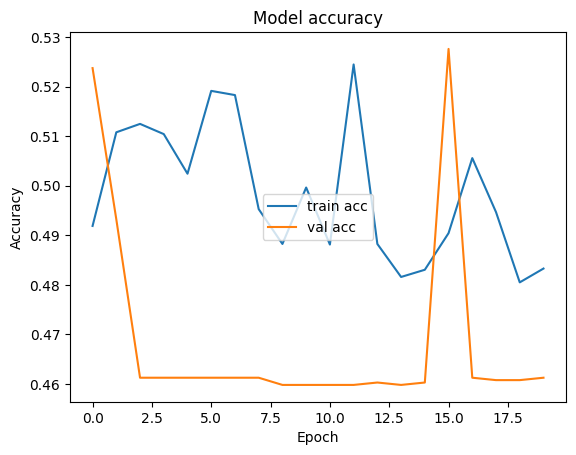

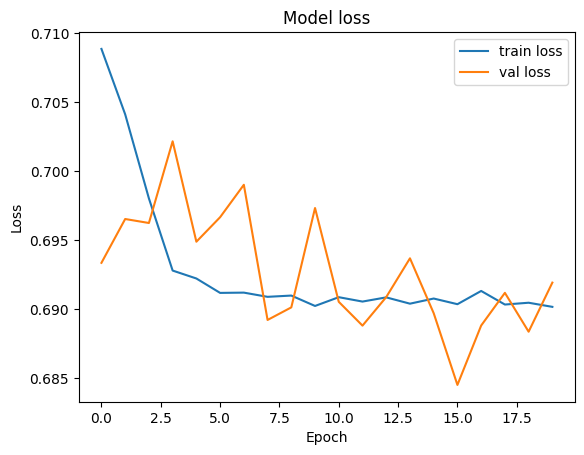

In [ ]:
hist = rnn.train(X_train, y_train, epochs=20, batch_size=64)
plot_history(hist)

In [ ]:
biLSTM = BiLSTM()
biLSTM.build()
biLSTM.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 933)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_10 (Embedding)        │ (None, 933, 300)       │     3,334,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 933, 256)       │       439,296 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 933, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 933, 128)       │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 933, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,979,729 (15.18 MB)

 Trainable params: 3,979,729 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 39s 263ms/step - accuracy: 0.7019 - loss: 0.5562 - val_accuracy: 0.8587 - val_loss: 0.3884
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 33s 256ms/step - accuracy: 0.8911 - loss: 0.3717 - val_accuracy: 0.8775 - val_loss: 0.3434
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 33s 255ms/step - accuracy: 0.8964 - loss: 0.3286 - val_accuracy: 0.8262 - val_loss: 0.4078
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 41s 257ms/step - accuracy: 0.7887 - loss: 0.4948 - val_accuracy: 0.8645 - val_loss: 0.3658
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 33s 255ms/step - accuracy: 0.8919 - loss: 0.3125 - val_accuracy: 0.8582 - val_loss: 0.4030
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 33s 254ms/step - accuracy: 0.9307 - loss: 0.2295 - val_accuracy: 0.8843 - val_loss: 0.3095
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 33s 255ms/step - accuracy: 0.9319 - loss: 0.2284 - val_accuracy: 0.8417 - val_loss: 0.4389
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 41s 256ms/step - accuracy: 0.9388 - loss: 0

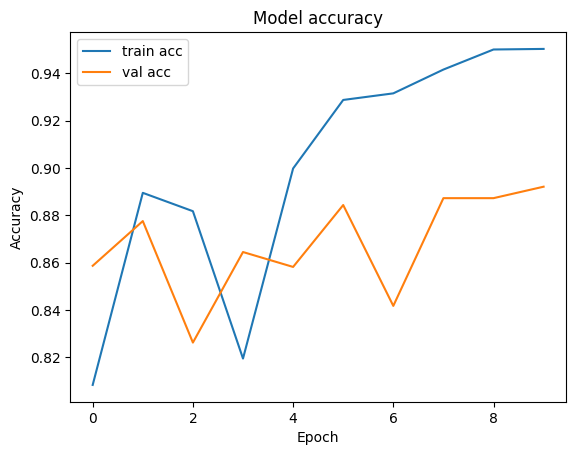

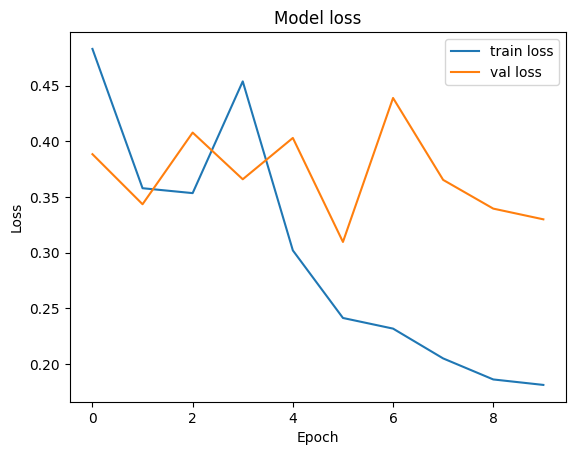

In [ ]:
hist = biLSTM.train(X_train, y_train, epochs=10, batch_size=64)
plot_history(hist)

In [ ]:
cnn_lstm = CNN_LSTM()
cnn_lstm.build()
cnn_lstm.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 933)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_14 (Embedding)        │ (None, 933, 300)       │     3,334,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 931, 128)       │       115,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 931, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 465, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,470,769 (13.24 MB)

 Trainable params: 3,470,769 (13.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.4208 - loss: 0.7037 - val_accuracy: 0.7401 - val_loss: 0.6887
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.5974 - loss: 0.6945 - val_accuracy: 0.7401 - val_loss: 0.6860
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6325 - loss: 0.6911 - val_accuracy: 0.2594 - val_loss: 0.6935
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.5940 - loss: 0.6880 - val_accuracy: 0.7401 - val_loss: 0.6917
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.6948 - loss: 0.6930 - val_accuracy: 0.7401 - val_loss: 0.6924
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.4122 - loss: 0.6885 - val_accuracy: 0.2594 - val_loss: 0.6949
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.4475 - loss: 0.6851 - val_accuracy: 0.2594 - val_loss: 0.6948
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.3065 - loss: 0.6959 - val_accu

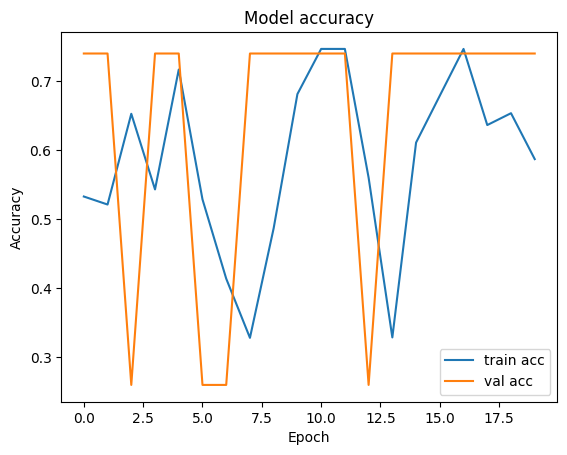

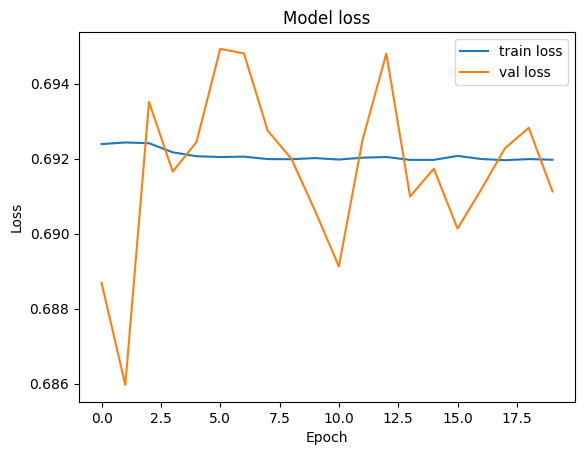

In [ ]:
hist = cnn_lstm.train(X_train, y_train, epochs=20, batch_size=64)
plot_history(hist)

In [ ]:
rnn.save(base + "/Model/rnn.h5")
biLSTM.save(base + "/Model/biLSTM.h5")
cnn_lstm.save(base + "/Model/cnn_lstm.h5")

## Testing

In [19]:
rnn_predicted = rnn.predict(X_test)
biLSTM_predicted = biLSTM.predict(X_test)
cnn_lstm_predicted = cnn_lstm.predict(X_test)

81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [20]:
rnn_predicted = np.round(rnn_predicted)
biLSTM_predicted = np.round(biLSTM_predicted)
cnn_lstm_predicted = np.round(cnn_lstm_predicted)

              precision    recall  f1-score   support

         0.0       0.28      0.64      0.39       657
         1.0       0.78      0.43      0.56      1925

    accuracy                           0.48      2582
   macro avg       0.53      0.53      0.47      2582
weighted avg       0.65      0.48      0.51      2582



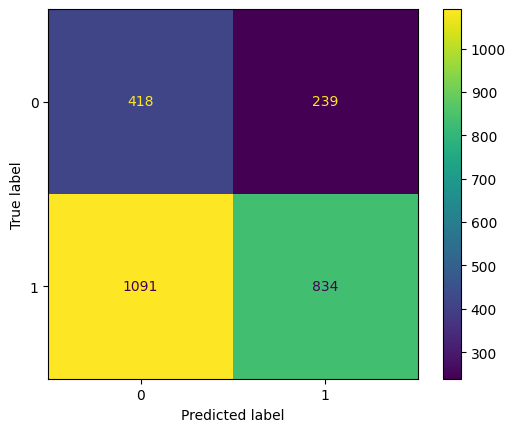

In [27]:
print(classification_report(y_test, rnn_predicted))
cm = confusion_matrix(y_test, rnn_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

              precision    recall  f1-score   support

         0.0       0.85      0.70      0.77       657
         1.0       0.90      0.96      0.93      1925

    accuracy                           0.89      2582
   macro avg       0.88      0.83      0.85      2582
weighted avg       0.89      0.89      0.89      2582



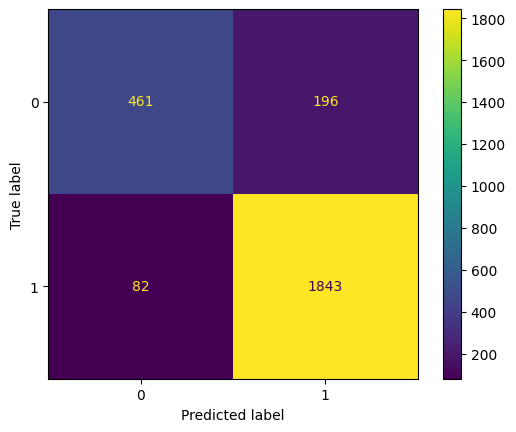

In [28]:
print(classification_report(y_test, biLSTM_predicted))
cm = confusion_matrix(y_test, biLSTM_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       657
         1.0       0.75      1.00      0.85      1925

    accuracy                           0.75      2582
   macro avg       0.37      0.50      0.43      2582
weighted avg       0.56      0.75      0.64      2582



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


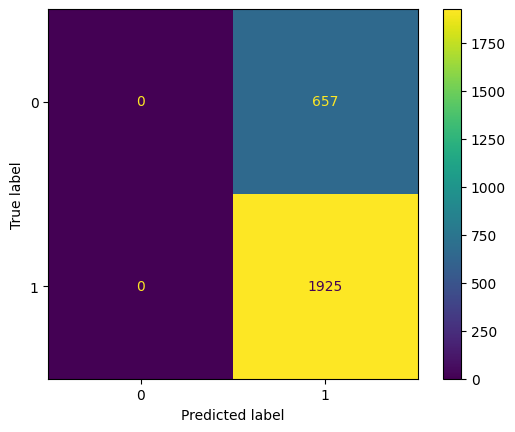

In [29]:
print(classification_report(y_test, cnn_lstm_predicted))
cm = confusion_matrix(y_test, cnn_lstm_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()